In [1]:
%load_ext autoreload
%autoreload 2

import json
import numpy as np

experiment_name = "N50000_t500_b100_lr1_5_D1_pi_double_norm" # "N50000_t500_b100_lr1_5_D1_pi_double_norm"
experiment_name_oscillations = "N50000_t500_b100_lr1_5_D1_pi_double_norm_oscillations"
bellman_iterations_scopes = [1, 4, 7, 10, 20]
seeds = [int(f"1{idx}") for idx in range(1, 21)]

p = json.load(open(f"figures/{experiment_name}/parameters.json"))

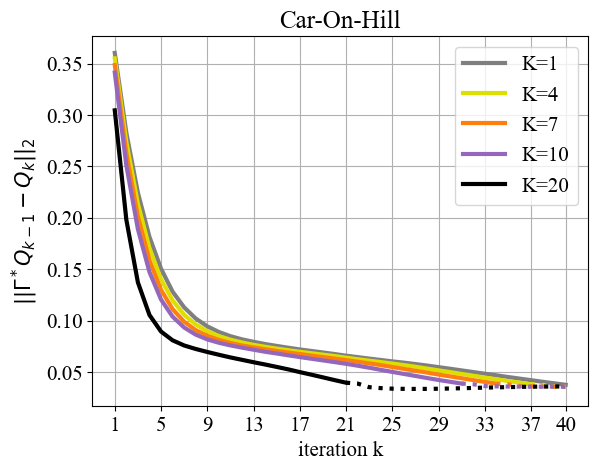

In [2]:
import matplotlib.pyplot as plt 

from experiments.car_on_hill import COLORS


plt.rc("font", size=15, family='serif', serif="Times New Roman")
plt.rc("lines", linewidth=3)

final_sum_approx_errors = {}


for idx_bellman_iterations_scope, bellman_iterations_scope in enumerate(bellman_iterations_scopes):
    approx_errors_seeds = []
    for seed in seeds:
        approx_errors_seeds.append(np.load(f"figures/{experiment_name}/iFQI_bound/{bellman_iterations_scope}_approx_errors_s{seed}.npy"))

    approx_errors = np.array(approx_errors_seeds).mean(axis=0)
    final_sum_approx_errors[bellman_iterations_scope] = np.around(np.sum(approx_errors[1:]), 4)

    frozen_line = p["n_bellman_iterations"] - bellman_iterations_scope + 1
    plt.plot(range(1, frozen_line + 1), approx_errors[1: frozen_line + 1], label=f"K={bellman_iterations_scope}", c=COLORS[str(bellman_iterations_scope)])
    plt.plot(range(frozen_line, p["n_bellman_iterations"] + 1), approx_errors[frozen_line:], linestyle="dotted", c=COLORS[str(bellman_iterations_scope)])

plt.xticks(list(range(1, p["n_bellman_iterations"] + 1, 4)) + [p["n_bellman_iterations"]])
plt.xlabel("iteration k")
plt.ylabel(r"$|| \Gamma^* Q_{k-1} - Q_k ||_2$")
plt.title("Car-On-Hill")
plt.legend().set_zorder(3)
plt.grid(zorder=0)
# _ = plt.savefig(f"figures/{experiment_name}/distance_to_optimal_Q.pdf", bbox_inches='tight')

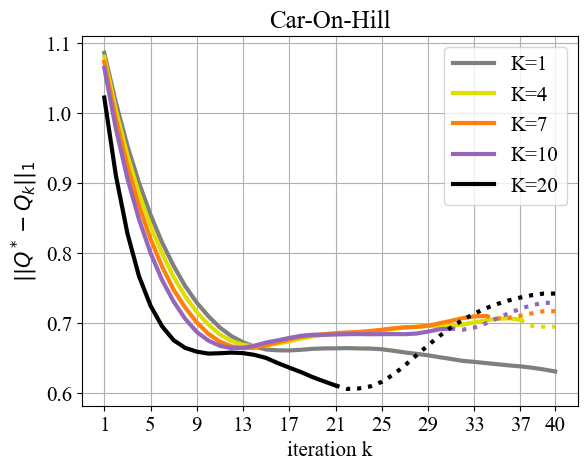

In [3]:
for idx_bellman_iterations_scope, bellman_iterations_scope in enumerate(bellman_iterations_scopes):
    diff_q_values_seeds = []
    for seed in seeds:
        diff_q_values_seeds.append(np.load(f"figures/{experiment_name}/iFQI_bound/{bellman_iterations_scope}_distance_Q_l1_s{seed}.npy"))

    diff_q_values = np.array(diff_q_values_seeds).mean(axis=0)

    frozen_line = p["n_bellman_iterations"] - bellman_iterations_scope + 1
    plt.plot(range(1, frozen_line + 1), diff_q_values[1: frozen_line + 1], label=f"K={bellman_iterations_scope}", c=COLORS[str(bellman_iterations_scope)])
    plt.plot(range(frozen_line, p["n_bellman_iterations"] + 1), diff_q_values[frozen_line:], linestyle="dotted", c=COLORS[str(bellman_iterations_scope)])
    
plt.xticks(list(range(1, p["n_bellman_iterations"] + 1, 4)) + [p["n_bellman_iterations"]])
plt.xlabel("iteration k")
plt.ylabel(r"$|| Q^* - Q_k ||_1$")
plt.title("Car-On-Hill")
plt.legend().set_zorder(3)
plt.grid(zorder=0)
# _ = plt.savefig(f"figures/{experiment_name}/distance_to_optimal_Q.pdf", bbox_inches='tight')

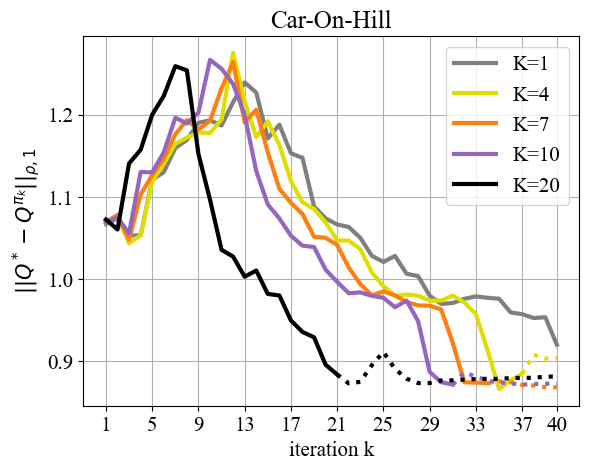

In [4]:
for idx_bellman_iterations_scope, bellman_iterations_scope in enumerate(bellman_iterations_scopes):
    diff_q_pi_values_seeds = []
    for seed in seeds:
        diff_q_pi_values_seeds.append(np.load(f"figures/{experiment_name}/iFQI_bound/{bellman_iterations_scope}_distance_Q_l1_pi_s{seed}.npy"))

    diff_q_pi_values = np.array(diff_q_pi_values_seeds).mean(axis=0)

    frozen_line = p["n_bellman_iterations"] - bellman_iterations_scope + 1
    plt.plot(range(1, frozen_line + 1), diff_q_pi_values[1: frozen_line + 1], label=f"K={bellman_iterations_scope}", c=COLORS[str(bellman_iterations_scope)])
    plt.plot(range(frozen_line, p["n_bellman_iterations"] + 1), diff_q_pi_values[frozen_line:], linestyle="dotted", c=COLORS[str(bellman_iterations_scope)])
    
plt.xticks(list(range(1, p["n_bellman_iterations"] + 1, 4)) + [p["n_bellman_iterations"]])
plt.xlabel("iteration k")
plt.ylabel(r"$|| Q^* - Q^{\pi_k} ||_{\rho, 1}$")
plt.title("Car-On-Hill")
plt.legend().set_zorder(3)
plt.grid(zorder=0)
# _ = plt.savefig(f"figures/{experiment_name}/distance_to_optimal_Q.pdf", bbox_inches='tight')

In [23]:
import pandas as pd

bound_infos = {
    "K" : [],
    "Final sum approx error": [],
    "% AE loss" : [],
    "E[AE gain]" : [],
    "% condition valid when AE < 0" : [],
    "% condition valid when AE >= 0" : [],
    "% AE gain when condition valid" : [],
    "----": [],
    "E[condition]" : [],
    "std[condition]" : [],
    "std[AE gain]" : [],
}


for idx_bellman_iterations_scope, bellman_iterations_scope in enumerate(bellman_iterations_scopes):
    bound_info = np.load(f"figures/{experiment_name}/iFQI_bound/{bellman_iterations_scope}_bound_info_s{seeds[0]}.npy")

    mean_condition, mean_approx_error_gain = np.mean(bound_info, axis=0)
    std_condition, std_approx_error_gain = np.std(bound_info, axis=0)
    mean_approx_error_gain_when_cond = np.mean(bound_info[bound_info[:, 0] >= 0, 1])
    percentage_approx_error_loss = np.around(100 * np.mean(bound_info[:, 1] < 0, axis=0))
    percentage_condition_approx_error_gain = np.around(100 * np.mean(bound_info[bound_info[:, 1] >= 0, 0] >= 0))
    if np.sum(bound_info[:, 1] < 0) > 0:
        percentage_wrong_condition = np.around(100 * np.mean(bound_info[bound_info[:, 1] < 0, 0] >= 0))
    else: 
        percentage_wrong_condition = 0
    percentage_approx_error_gain_when_condition = np.around(100 * np.sum(bound_info[bound_info[:, 0] >= 0, 1]) / np.sum(bound_info[bound_info[:, 1] >= 0, 1]))

    bound_infos["K"].append(bellman_iterations_scope)
    bound_infos["Final sum approx error"].append(final_sum_approx_errors[bellman_iterations_scope])
    bound_infos["% AE loss"].append(percentage_approx_error_loss)
    bound_infos["E[AE gain]"].append(mean_approx_error_gain)
    bound_infos["% condition valid when AE < 0"].append(percentage_wrong_condition)
    bound_infos["% condition valid when AE >= 0"].append(percentage_condition_approx_error_gain)
    bound_infos["% AE gain when condition valid"].append(percentage_approx_error_gain_when_condition)
    bound_infos["----"].append("-")
    bound_infos["E[condition]"].append(mean_condition)
    bound_infos["std[condition]"].append(std_condition)
    bound_infos["std[AE gain]"].append(std_approx_error_gain)

pd.DataFrame(bound_infos).round(5)

,K,Final sum approx error,% AE loss,E[AE gain],% condition valid when AE < 0,% condition valid when AE >= 0,% AE gain when condition valid,----,E[condition],std[condition],std[AE gain]
0,1,3.5155,0.0,0.00003,0.0,100.0,100.0,-,0.00003,0.00004,0.00006
1,4,3.3543,17.0,0.00015,0.0,17.0,68.0,-,-0.00003,0.00003,0.00033
2,7,3.1882,23.0,0.00026,0.0,17.0,69.0,-,-0.00004,0.00003,0.00060
3,10,3.0189,23.0,0.00038,0.0,17.0,66.0,-,-0.00004,0.00003,0.00087
4,20,2.4345,24.0,0.00078,0.0,17.0,67.0,-,-0.00004,0.00003,0.00178


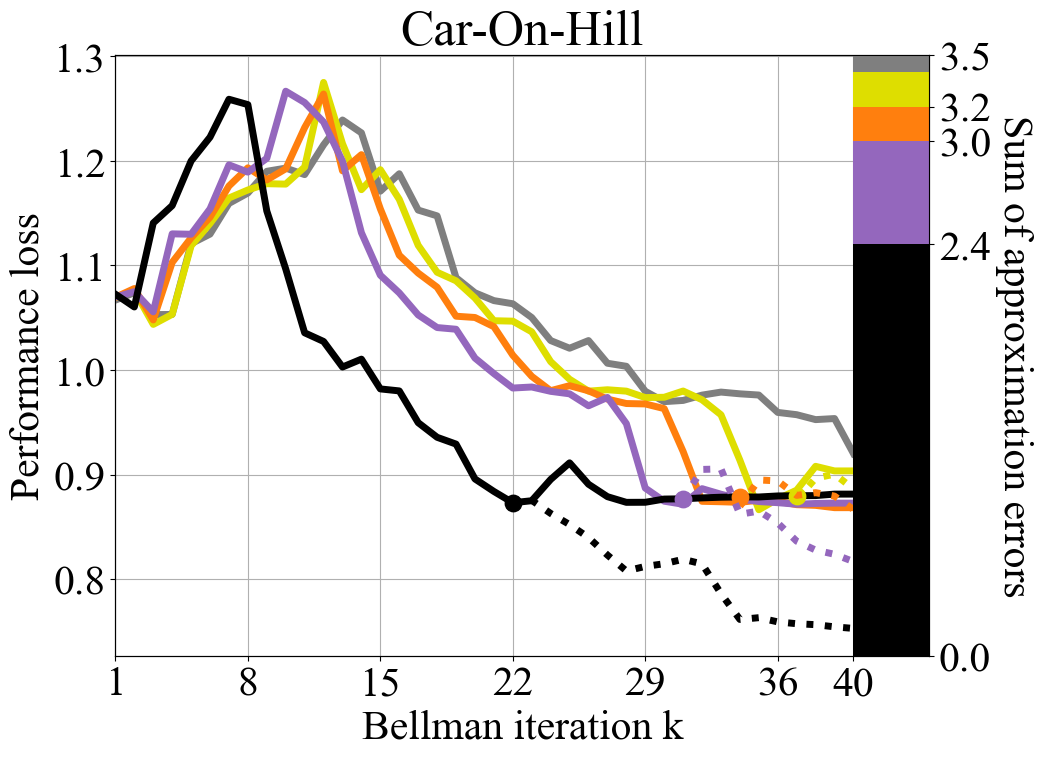

<Figure size 1500x1000 with 0 Axes>

In [6]:
import matplotlib.pyplot as plt 

from experiments.car_on_hill import COLORS


plt.rc("font", size=30, family='serif', serif="Times New Roman")
plt.rc("lines", linewidth=5)

fig = plt.figure(figsize=(10.5, 7.8))
ax = fig.add_subplot(111)
fig_legend = plt.figure(figsize=(15, 10))
lines = []
sum_approxs = list(np.around(bound_infos["Final sum approx error"], 1))

ax_approx = ax.twinx()

for idx_bellman_iterations_scope, bellman_iterations_scope in enumerate(bellman_iterations_scopes):
    diff_q_pi_values_seeds = []
    for seed in seeds:
        diff_q_pi_values_seeds.append(np.load(f"figures/{experiment_name}/iFQI_bound/{bellman_iterations_scope}_distance_Q_l1_pi_s{seed}.npy"))

    diff_q_pi_values = np.array(diff_q_pi_values_seeds).mean(axis=0)
    # diff_v_values_std = np.array(diff_v_values_seeds).std(axis=0)

    frozen_line = p["n_bellman_iterations"] - bellman_iterations_scope + 1
    # lines.append(ax.plot(range(1, frozen_line + 1), diff_v_values[1: frozen_line + 1], label=f"K={bellman_iterations_scope}", c=COLORS[str(bellman_iterations_scope)]))
    # ax.plot(range(frozen_line, p["n_bellman_iterations"] + 1), diff_v_values[frozen_line:], linestyle="dotted", c=COLORS[str(bellman_iterations_scope)])
    lines.append(ax.plot(range(1, p["n_bellman_iterations"] + 1), diff_q_pi_values[1:], label=f"K={bellman_iterations_scope}", c=COLORS[str(bellman_iterations_scope)], zorder=idx_bellman_iterations_scope + 3))

    # ax.fill_between(range(p["n_bellman_iterations"] + 1), diff_v_values - diff_v_values_std, diff_v_values + diff_v_values_std, label=f"K={bellman_iterations_scope}", color=COLORS[str(bellman_iterations_scope)])

for idx_bellman_iterations_scope, bellman_iterations_scope in enumerate([4, 7, 10, 20]):
    diff_q_pi_later_values_seeds = []
    for seed in seeds:
        diff_q_pi_later_values_seeds.append(np.load(f"figures/{experiment_name_oscillations}/iFQI_bound/{bellman_iterations_scope}_distance_Q_l1_pi_s{seed}.npy"))

    diff_q_pi_later_values = np.array(diff_q_pi_later_values_seeds).mean(axis=0)
    # diff_v_values_std = np.array(diff_v_values_seeds).std(axis=0)

    if bellman_iterations_scope == 20:
        frozen_line = p["n_bellman_iterations"] - bellman_iterations_scope + 2
    else:
        frozen_line = p["n_bellman_iterations"] - bellman_iterations_scope + 1

    ax.plot(range(frozen_line, p["n_bellman_iterations"] + 1), diff_q_pi_later_values[frozen_line: p["n_bellman_iterations"] + 1], linestyle="dotted", c=COLORS[str(bellman_iterations_scope)], zorder=idx_bellman_iterations_scope + 23)

    # ax.fill_between(range(p["n_bellman_iterations"] + 1), diff_v_values - diff_v_values_std, diff_v_values + diff_v_values_std, label=f"K={bellman_iterations_scope}", color=COLORS[str(bellman_iterations_scope)])
    ax.scatter(frozen_line, [diff_q_pi_values[frozen_line]], s=140, c=COLORS[str(bellman_iterations_scope)], zorder=idx_bellman_iterations_scope + 23)

ax.set_xticks(list(range(1, p["n_bellman_iterations"] + 1, 7)) + [p["n_bellman_iterations"]])
ax.set_xlim(1, p["n_bellman_iterations"] + 4)
ax.set_xlabel("Bellman iteration k")
ax.set_ylabel("Performance loss")
ax.set_title("Car-On-Hill")
ax.grid(zorder=0)

bars = ax_approx.bar(p["n_bellman_iterations"] + 2, sum_approxs, 4, color=[COLORS[str(bellman_iter)] for bellman_iter in bellman_iterations_scopes])
ax_approx.set_yticks([0] + [sum_approxs[0]] + sum_approxs[2:])
ax_approx.set_ylim(0, max(sum_approxs))
ax_approx.set_ylabel("Sum of approximation errors", rotation=-90, labelpad=30)

fig.savefig(f"figures/{experiment_name}/pi_approx.pdf")

fig_legend.legend([line[0] for line in lines],  [line[0].get_label() for line in lines], ncols=5, frameon=False, fontsize=32, columnspacing=0.9)
_ = fig_legend.savefig(f"figures/{experiment_name}/pi_approx_legend.pdf")